In [1]:
import wmfdata
from wmfdata import hive
import pandas as pd
from datetime import datetime, timedelta, date

In [2]:
from pandas.plotting import scatter_matrix

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
@ticker.FuncFormatter
def million_formatter(x, pos):
    return "%d M" % round(x/1000000)
@ticker.FuncFormatter
def thousand_formatter(x, pos):
    return "%d K" % round(x/1000)

In [4]:
import prophet
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [70]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [5]:
start_month='2018-07'
end_month='2021-02'

## Ptwiki daily edits percentage by BR and PT

In [8]:
query_daily_edits_by_country='''
select `date`, 
SUM(CASE WHEN country_code='BR' THEN edit_count WHEN country_code='PT' THEN edit_count ELSE 0 END)/sum(edit_count) AS BR_PT_edits_rate
FROM wmf.editors_daily
WHERE (month between '{START_YYYY_MM}' and '{END_YYYY_MM}') AND  size(user_is_bot_by) <= 0 and wiki_db='ptwiki'
GROUP BY `date`
ORDER BY `date`
LIMIT 100000
'''

In [9]:
df_daily_edits_by_country=hive.run(query_daily_edits_by_country.format(START_YYYY_MM=start_month, END_YYYY_MM=end_month))

In [10]:
df_daily_edits_by_country.head()

,date,br_pt_edits_rate
0,2019-10-01,0.939467
1,2019-10-02,0.945686
2,2019-10-03,0.950181
3,2019-10-04,0.936007
4,2019-10-05,0.914676


## Esitimate ptwiki non-reverted (exculding bot and revert edits) by coutry using the geo edits_ratio from wmf.editors_daily
wmf.editors_daily has edits data by geo country since 2019-10-01, without any fields indicating whether it's a reverted edit or a revert edit. We have to estimate the net edits by coutry using the geo ratio of non-bot edits.  

### Data timeframe used for modeling:
Fitting: 2019-10-01 ~ 2020-10-03  
Cross Validation: 2020-07-05 ~ 2020-10-03  
Forecast: 2020-10-04 ~ 2020-02-28  

In [13]:
query_daily_non_reverted_nonbot_edits_48hr_exclude_revert_edits='''
WITH t1 AS
(
SELECT wiki_db, date_format(event_timestamp,'yyyy-MM-dd') AS ds,
 count(revision_id) AS non_reverted_edits
FROM wmf.mediawiki_history
WHERE snapshot= '{SNAPSHOT}' AND wiki_db IN ('ptwiki','enwiki')
    -- for bots size(event_user_is_bot_by) returns 1/2, IP editors return -1, registered non-bot editors return 0
    AND  size(event_user_is_bot_by) <= 0 
    AND substr(event_timestamp,1,10) BETWEEN '{START_YYYY_MM_DD}' AND '{END_YYYY_MM_DD}'
    AND event_entity = "revision" AND (NOT revision_is_identity_reverted  OR revision_seconds_to_identity_revert > 172800)
GROUP BY wiki_db, date_format(event_timestamp,'yyyy-MM-dd')
ORDER BY ds
LIMIT 1000000
),
t2 AS
(
SELECT h1.wiki_db, date_format(h1.event_timestamp,'yyyy-MM-dd') AS ds,
    count(distinct h1.revision_id) AS revert_edits
FROM wmf.mediawiki_history AS h1 
LEFT JOIN wmf.mediawiki_history AS h2  -- h1 is revert edits, h2 is the edits being reverted
ON h1.revision_id=h2.revision_first_identity_reverting_revision_id  
      AND h1.wiki_db = h2.wiki_db
      AND h1.snapshot= h2.snapshot 
WHERE h1.wiki_db IN ('ptwiki', 'enwiki') AND h1.snapshot='{SNAPSHOT}'
    -- for bots size(event_user_is_bot_by) returns 1 or 2, IP editors return -1, registered non-bot editors return 0
    AND size(h1.event_user_is_bot_by) <= 0 AND size(h2.event_user_is_bot_by) <= 0
    AND substr(h1.event_timestamp,1,10) BETWEEN '{START_YYYY_MM_DD}' AND '{END_YYYY_MM_DD}'
    AND h1.event_entity = "revision" and h2.event_entity = "revision" 
    AND (NOT h1.revision_is_identity_reverted  OR h1.revision_seconds_to_identity_revert > 172800)
    AND h2.revision_is_identity_reverted AND h2.revision_seconds_to_identity_revert < 172800
    AND h1.revision_is_identity_revert
    AND h1.event_entity = 'revision' and  h2.event_entity = 'revision'
GROUP BY h1.wiki_db , date_format(h1.event_timestamp,'yyyy-MM-dd')
ORDER BY ds
LIMIT 1000000
)
SELECT t1.wiki_db, t1.ds, t1.non_reverted_edits - t2.revert_edits AS net_non_reverted_edits
FROM  t1
LEFT JOIN t2 ON t1.ds=t2.ds AND t1.wiki_db=t2.wiki_db
'''

In [14]:
df_net_edits=hive.run(query_daily_non_reverted_nonbot_edits_48hr_exclude_revert_edits.format(SNAPSHOT='2021-02', START_YYYY_MM_DD='2019-10-01', END_YYYY_MM_DD='2021-02-28' ))

In [15]:
df_net_edits

,wiki_db,ds,net_non_reverted_edits
0,enwiki,2019-10-01,126948
1,ptwiki,2019-10-01,5416
2,enwiki,2019-10-02,116508
3,ptwiki,2019-10-02,5632
4,ptwiki,2019-10-03,5027
...,...,...,...
1029,enwiki,2021-02-26,134533
1030,enwiki,2021-02-27,127077
1031,ptwiki,2021-02-27,5312
1032,enwiki,2021-02-28,140644


In [16]:
df_net_edits_ptwiki=df_net_edits[df_net_edits['wiki_db']=='ptwiki'][['ds','net_non_reverted_edits']]
df_net_edits_ptwiki.head()

,ds,net_non_reverted_edits
1,2019-10-01,5416
3,2019-10-02,5632
4,2019-10-03,5027
6,2019-10-04,5332
8,2019-10-05,5332


In [17]:
df_net_edits_ptwiki=df_net_edits_ptwiki.merge(df_daily_edits_by_country, left_on='ds', right_on='date', how='left')

In [18]:
df_net_edits_ptwiki['estimate_net_edits_country_BR_PT']=(df_net_edits_ptwiki['net_non_reverted_edits']*df_net_edits_ptwiki['br_pt_edits_rate']).round(0)

In [19]:
df_net_edits_ptwiki['estimate_net_edits_country_BR_PT']=(df_net_edits_ptwiki['net_non_reverted_edits']*df_net_edits_ptwiki['br_pt_edits_rate']).round(0)

In [20]:
df_net_edits_ptwiki.head()

,ds,net_non_reverted_edits,date,br_pt_edits_rate,estimate_net_edits_country_BR_PT
0,2019-10-01,5416,2019-10-01,0.939467,5088.0
1,2019-10-02,5632,2019-10-02,0.945686,5326.0
2,2019-10-03,5027,2019-10-03,0.950181,4777.0
3,2019-10-04,5332,2019-10-04,0.936007,4991.0
4,2019-10-05,5332,2019-10-05,0.914676,4877.0


## Enwiki daily edits percentage by BR and PT

In [21]:
query_enwiki_daily_edits_by_country='''
select `date`, 
SUM(CASE WHEN country_code='BR' THEN edit_count WHEN country_code='PT' THEN edit_count  ELSE 0 END)/sum(edit_count) AS BR_PT_edits_rate
FROM wmf.editors_daily
WHERE (month between '{START_YYYY_MM}' and '{END_YYYY_MM}') AND  size(user_is_bot_by) <= 0 and wiki_db='enwiki'
GROUP BY `date`
ORDER BY `date`
LIMIT 100000
'''

In [23]:
df_enwiki_daily_edits_by_country=hive.run(query_enwiki_daily_edits_by_country.format(START_YYYY_MM=start_month, END_YYYY_MM=end_month))

In [24]:
df_enwiki_daily_edits_by_country.head()

,date,br_pt_edits_rate
0,2019-10-01,0.006591
1,2019-10-02,0.007526
2,2019-10-03,0.008280
3,2019-10-04,0.008069
4,2019-10-05,0.007131


## Esitimate enwiki non-reverted (exculding bot and revert edits) by coutry using the geo edits_ratio from wmf.editors_daily

In [25]:
df_net_edits_enwiki=df_net_edits[df_net_edits['wiki_db']=='enwiki'][['ds','net_non_reverted_edits']]
df_net_edits_enwiki.head()

,ds,net_non_reverted_edits
0,2019-10-01,126948
2,2019-10-02,116508
5,2019-10-03,113734
7,2019-10-04,114695
9,2019-10-05,120017


In [26]:
df_net_edits_enwiki=df_net_edits_enwiki.merge(df_enwiki_daily_edits_by_country, left_on='ds', right_on='date', how='left')

In [27]:
df_net_edits_enwiki['estimate_enwiki_net_edits_country_BR_PT']=(df_net_edits_enwiki['net_non_reverted_edits']*df_net_edits_enwiki['br_pt_edits_rate']).round(0)

In [28]:
df_net_edits_enwiki.head()

,ds,net_non_reverted_edits,date,br_pt_edits_rate,estimate_enwiki_net_edits_country_BR_PT
0,2019-10-01,126948,2019-10-01,0.006591,837.0
1,2019-10-02,116508,2019-10-02,0.007526,877.0
2,2019-10-03,113734,2019-10-03,0.008280,942.0
3,2019-10-04,114695,2019-10-04,0.008069,925.0
4,2019-10-05,120017,2019-10-05,0.007131,856.0


In [29]:
df=pd.merge(df_net_edits_ptwiki[['ds','estimate_net_edits_country_BR_PT']],
            df_net_edits_enwiki[['ds','estimate_enwiki_net_edits_country_BR_PT']], 
            left_on='ds', right_on='ds', how='left')

In [30]:
df.columns=['ds','ptwiki_net_edits_from_BR_PT', 'enwiki_net_edits_from_BR_PT' ]

# Data Characteristics

In [31]:
df.head()

,ds,ptwiki_net_edits_from_BR_PT,enwiki_net_edits_from_BR_PT
0,2019-10-01,5088.0,837.0
1,2019-10-02,5326.0,877.0
2,2019-10-03,4777.0,942.0
3,2019-10-04,4991.0,925.0
4,2019-10-05,4877.0,856.0


In [32]:
df.ds=pd.to_datetime(df.ds)


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517 entries, 0 to 516
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ds                           517 non-null    datetime64[ns]
 1   ptwiki_net_edits_from_BR_PT  517 non-null    float64       
 2   enwiki_net_edits_from_BR_PT  517 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 16.2 KB


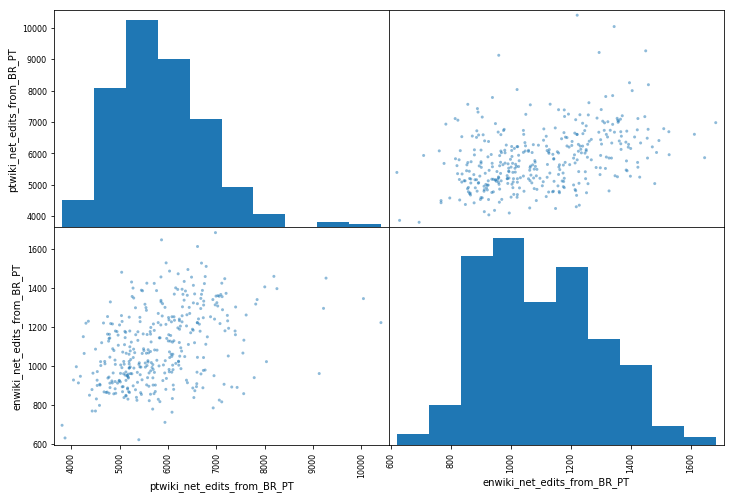

In [34]:
cols=['ptwiki_net_edits_from_BR_PT','enwiki_net_edits_from_BR_PT' ]
scatter_matrix(df[df.ds<'2020-10-4'][cols],figsize=(12,8))
plt.show()

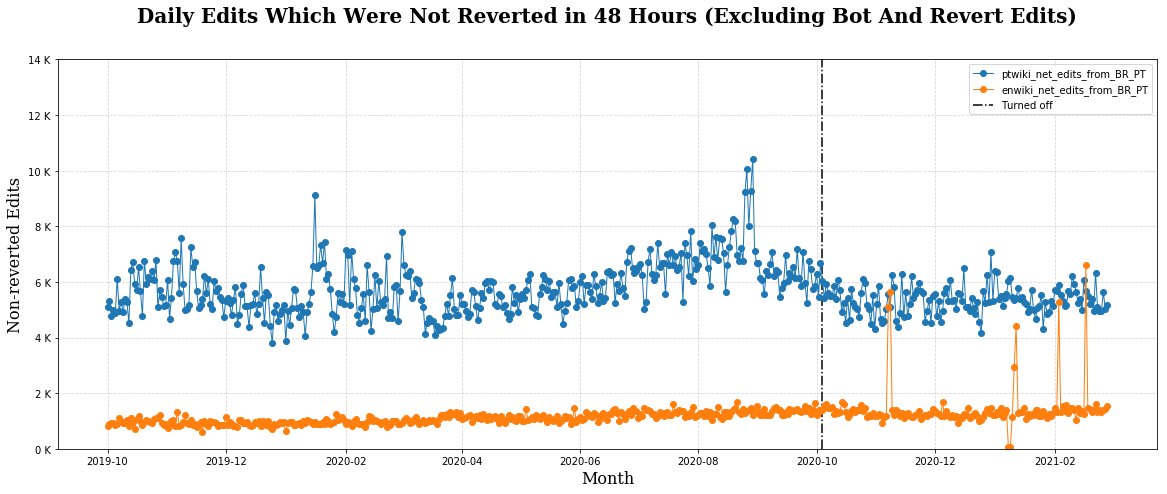

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=0.5)
ax.set_title('Daily Edits Which Were Not Reverted in 48 Hours (Excluding Bot And Revert Edits)',fontweight="bold",fontsize = 20, family='serif', y=1.08)
ax.set_xlabel('Month',  fontsize = 16, family='serif')
ax.set_ylabel('Non-reverted Edits',  fontsize = 16, family='serif')

ax.plot(pd.to_datetime(df['ds']).dt.to_pydatetime(), df['ptwiki_net_edits_from_BR_PT'],'o-',label= 'ptwiki_net_edits_from_BR_PT',linewidth=1)
ax.plot(pd.to_datetime(df['ds']).dt.to_pydatetime(), df['enwiki_net_edits_from_BR_PT'],'o-',label= 'enwiki_net_edits_from_BR_PT',linewidth=1)


ax.yaxis.set_major_formatter(thousand_formatter)
ax.set_ylim(0,14000)
ax.vlines(x=datetime(2020, 10, 4, 0, 0), ymin=0, ymax=14000, colors='k', linestyles='dashdot', label='Turned off')
ax.legend(loc='upper right')

ax.grid(b=True, linestyle='--', alpha=0.5)
#ax.set_facecolor((.94,.95,.98))
#ax.margins(0.05, 0.2)
plt.show()

# Data Modeling for ptwiki edits from Brazil and Portugal

In [37]:
df_fit=df[df.ds < '2020-10-04'] [['ds','ptwiki_net_edits_from_BR_PT','enwiki_net_edits_from_BR_PT']]

In [38]:
df_fit.columns=['ds','y','enwiki_net_edits_from_BR_PT']

In [39]:
df_fit.head()

,ds,y,enwiki_net_edits_from_BR_PT
0,2019-10-01,5088.0,837.0
1,2019-10-02,5326.0,877.0
2,2019-10-03,4777.0,942.0
3,2019-10-04,4991.0,925.0
4,2019-10-05,4877.0,856.0


In [40]:
m = Prophet(interval_width=0.95)
m.add_regressor('enwiki_net_edits_from_BR_PT')
m.fit(df_fit)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
future = m.make_future_dataframe(periods=148, freq = "D")

future

,ds
0,2019-10-01
1,2019-10-02
2,2019-10-03
3,2019-10-04
4,2019-10-05
...,...
512,2021-02-24
513,2021-02-25
514,2021-02-26
515,2021-02-27


In [42]:
df_predict=df[['ds','enwiki_net_edits_from_BR_PT']]

In [43]:
future = future.merge(df_predict, 
                      left_on='ds', right_on='ds',  how='left')

In [44]:
future

,ds,enwiki_net_edits_from_BR_PT
0,2019-10-01,837.0
1,2019-10-02,877.0
2,2019-10-03,942.0
3,2019-10-04,925.0
4,2019-10-05,856.0
...,...,...
512,2021-02-24,1390.0
513,2021-02-25,1306.0
514,2021-02-26,1384.0
515,2021-02-27,1426.0


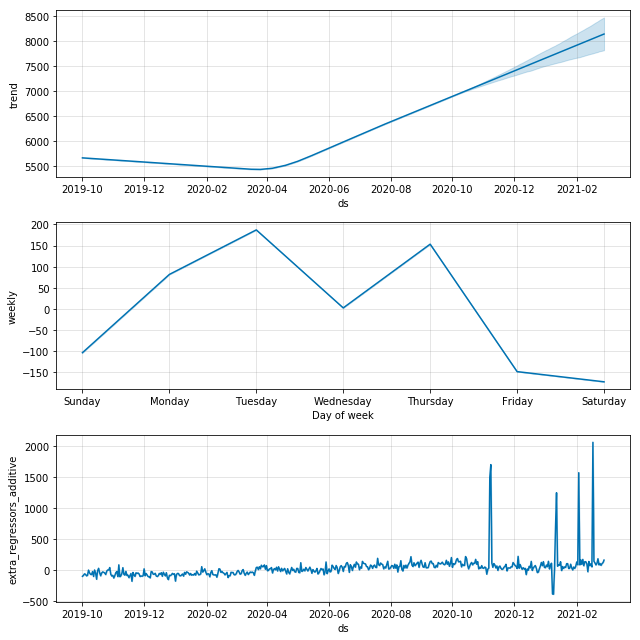

In [45]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

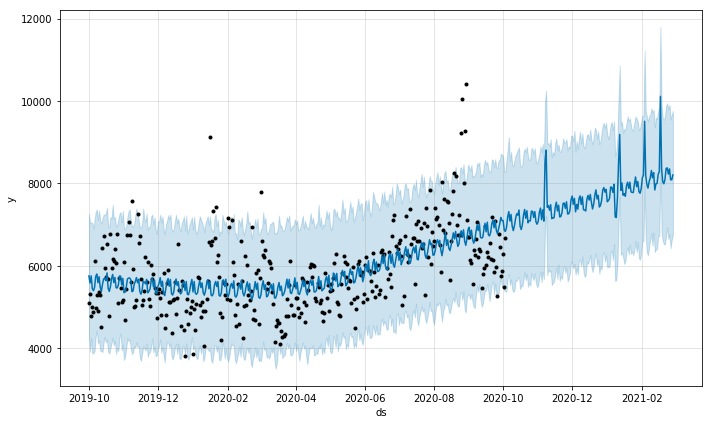

In [46]:
fig1 = m.plot(forecast)

In [47]:
df_real=df[df.ds >= '2020-10-04'] [['ds','ptwiki_net_edits_from_BR_PT']]

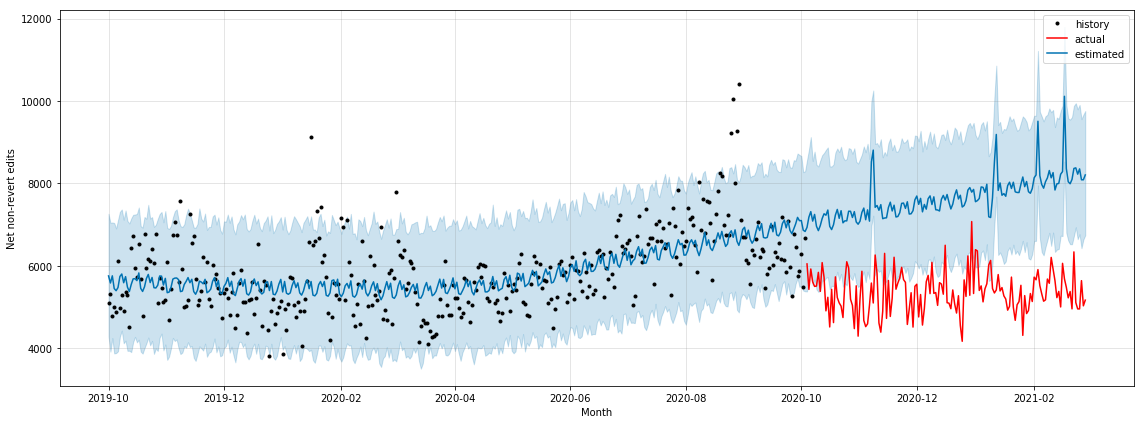

In [48]:
xlabel='Month'
ylabel='Net non-revert edits'
fig = plt.figure(facecolor='w', figsize=(16, 6))

ax = fig.add_subplot(111)
fcst_t = forecast['ds'].dt.to_pydatetime()
ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.', label='history')
ax.plot(df_real['ds'].dt.to_pydatetime(), df_real['ptwiki_net_edits_from_BR_PT'],'-',color='r', label='actual')
ax.plot(fcst_t, forecast['yhat'], ls='-', c='#0072B2',label='estimated')
ax.fill_between(fcst_t, forecast['yhat_lower'], forecast['yhat_upper'], color='#0072B2', alpha=0.2)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend(loc='upper right')
fig.tight_layout()

# Cross Validation

In [49]:
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics


In [50]:
df_cv = cross_validation(m, initial='270 days', period='10 days', horizon = '30 days')

INFO:prophet:Making 7 forecasts with cutoffs between 2020-07-05 00:00:00 and 2020-09-03 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

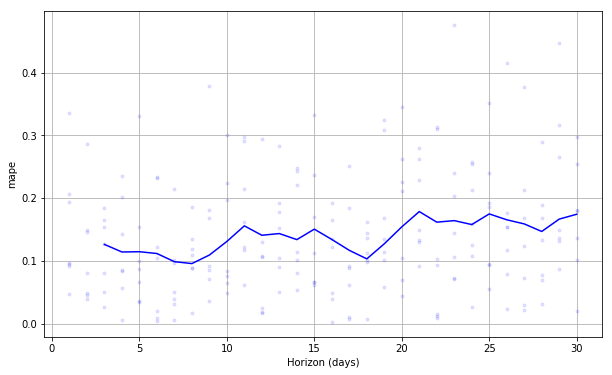

In [51]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [52]:
performance_metrics_results = performance_metrics(df_cv)
print(performance_metrics_results)

   horizon           mse         rmse          mae      mape     mdape  \
0   3 days  1.230600e+06  1109.324125   899.642901  0.126517  0.096292   
1   4 days  1.206373e+06  1098.350293   861.650302  0.114480  0.085992   
2   5 days  1.383661e+06  1176.291151   891.090464  0.114902  0.087129   
3   6 days  1.454167e+06  1205.888406   880.208921  0.112039  0.087129   
4   7 days  1.158767e+06  1076.460518   745.969623  0.099028  0.087129   
5   8 days  6.790324e+05   824.034234   662.265785  0.096034  0.096729   
6   9 days  7.107800e+05   843.077698   704.974301  0.109589  0.092572   
7  10 days  9.416790e+05   970.401479   839.278941  0.131260  0.092572   
8  11 days  1.302313e+06  1141.189222   993.081011  0.156063  0.122221   
9  12 days  1.454068e+06  1205.847465   971.501758  0.141107  0.117082   
10 13 days  1.492826e+06  1221.812473  1008.042428  0.143811  0.122221   
11 14 days  1.504131e+06  1226.430241   990.641008  0.134167  0.107813   
12 15 days  1.824462e+06  1350.726565 

## Residuals

In [57]:
estimate_history = m.predict(df_fit[['ds','enwiki_net_edits_from_BR_PT']])
df_estimate = pd.merge(df_fit, estimate_history, on='ds')


In [54]:
df_fit[['ds','enwiki_net_edits_from_BR_PT']]

,ds,enwiki_net_edits_from_BR_PT
0,2019-10-01,837.0
1,2019-10-02,877.0
2,2019-10-03,942.0
3,2019-10-04,925.0
4,2019-10-05,856.0
...,...,...
364,2020-09-29,1385.0
365,2020-09-30,1645.0
366,2020-10-01,1225.0
367,2020-10-02,1384.0


In [58]:
df_estimate

,ds,y,enwiki_net_edits_from_BR_PT_x,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-10-01,5088.0,837.0,5663.274835,4252.652504,7295.939238,5663.274835,5663.274835,89.159863,89.159863,...,-98.007007,-98.007007,-98.007007,187.166870,187.166870,187.166870,0.0,0.0,0.0,5752.434698
1,2019-10-02,5326.0,877.0,5661.897256,4081.685426,6938.818761,5661.897256,5661.897256,-80.599748,-80.599748,...,-83.055704,-83.055704,-83.055704,2.455957,2.455957,2.455957,0.0,0.0,0.0,5581.297509
2,2019-10-03,4777.0,942.0,5660.519678,4225.412569,7458.264204,5660.519678,5660.519678,94.587929,94.587929,...,-58.759837,-58.759837,-58.759837,153.347766,153.347766,153.347766,0.0,0.0,0.0,5755.107607
3,2019-10-04,4991.0,925.0,5659.142099,3863.393397,7152.255076,5659.142099,5659.142099,-213.567331,-213.567331,...,-65.114140,-65.114140,-65.114140,-148.453191,-148.453191,-148.453191,0.0,0.0,0.0,5445.574768
4,2019-10-05,4877.0,856.0,5657.764520,3885.054189,7003.406097,5657.764520,5657.764520,-263.487376,-263.487376,...,-90.905138,-90.905138,-90.905138,-172.582238,-172.582238,-172.582238,0.0,0.0,0.0,5394.277144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,2020-09-29,5762.0,1385.0,6879.174690,5649.652735,8766.617978,6879.174690,6879.174690,293.992715,293.992715,...,106.825845,106.825845,106.825845,187.166870,187.166870,187.166870,0.0,0.0,0.0,7173.167404
365,2020-09-30,5865.0,1645.0,6887.501237,5562.882322,8694.072391,6887.501237,6887.501237,206.465271,206.465271,...,204.009315,204.009315,204.009315,2.455957,2.455957,2.455957,0.0,0.0,0.0,7093.966508
366,2020-10-01,6289.0,1225.0,6895.827784,5389.615916,8689.665915,6895.827784,6895.827784,200.368399,200.368399,...,47.020633,47.020633,47.020633,153.347766,153.347766,153.347766,0.0,0.0,0.0,7096.196183
367,2020-10-02,5472.0,1384.0,6904.154332,5287.185671,8482.653695,6904.154332,6904.154332,-42.001128,-42.001128,...,106.452062,106.452062,106.452062,-148.453191,-148.453191,-148.453191,0.0,0.0,0.0,6862.153204


In [59]:

df_estimate['residuals'] = df_estimate['yhat'] - df_estimate['y']

In [60]:
df_estimate

,ds,y,enwiki_net_edits_from_BR_PT_x,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,residuals
0,2019-10-01,5088.0,837.0,5663.274835,4252.652504,7295.939238,5663.274835,5663.274835,89.159863,89.159863,...,-98.007007,-98.007007,187.166870,187.166870,187.166870,0.0,0.0,0.0,5752.434698,664.434698
1,2019-10-02,5326.0,877.0,5661.897256,4081.685426,6938.818761,5661.897256,5661.897256,-80.599748,-80.599748,...,-83.055704,-83.055704,2.455957,2.455957,2.455957,0.0,0.0,0.0,5581.297509,255.297509
2,2019-10-03,4777.0,942.0,5660.519678,4225.412569,7458.264204,5660.519678,5660.519678,94.587929,94.587929,...,-58.759837,-58.759837,153.347766,153.347766,153.347766,0.0,0.0,0.0,5755.107607,978.107607
3,2019-10-04,4991.0,925.0,5659.142099,3863.393397,7152.255076,5659.142099,5659.142099,-213.567331,-213.567331,...,-65.114140,-65.114140,-148.453191,-148.453191,-148.453191,0.0,0.0,0.0,5445.574768,454.574768
4,2019-10-05,4877.0,856.0,5657.764520,3885.054189,7003.406097,5657.764520,5657.764520,-263.487376,-263.487376,...,-90.905138,-90.905138,-172.582238,-172.582238,-172.582238,0.0,0.0,0.0,5394.277144,517.277144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,2020-09-29,5762.0,1385.0,6879.174690,5649.652735,8766.617978,6879.174690,6879.174690,293.992715,293.992715,...,106.825845,106.825845,187.166870,187.166870,187.166870,0.0,0.0,0.0,7173.167404,1411.167404
365,2020-09-30,5865.0,1645.0,6887.501237,5562.882322,8694.072391,6887.501237,6887.501237,206.465271,206.465271,...,204.009315,204.009315,2.455957,2.455957,2.455957,0.0,0.0,0.0,7093.966508,1228.966508
366,2020-10-01,6289.0,1225.0,6895.827784,5389.615916,8689.665915,6895.827784,6895.827784,200.368399,200.368399,...,47.020633,47.020633,153.347766,153.347766,153.347766,0.0,0.0,0.0,7096.196183,807.196183
367,2020-10-02,5472.0,1384.0,6904.154332,5287.185671,8482.653695,6904.154332,6904.154332,-42.001128,-42.001128,...,106.452062,106.452062,-148.453191,-148.453191,-148.453191,0.0,0.0,0.0,6862.153204,1390.153204


In [64]:
df_estimate['residuals'].describe()

count     369.000000
mean        0.602162
std       792.477799
min     -3911.005017
25%      -388.603679
50%       117.913192
75%       548.198017
max      1590.552501
Name: residuals, dtype: float64

In [67]:
df_estimate['residuals'].median()

117.91319237491825

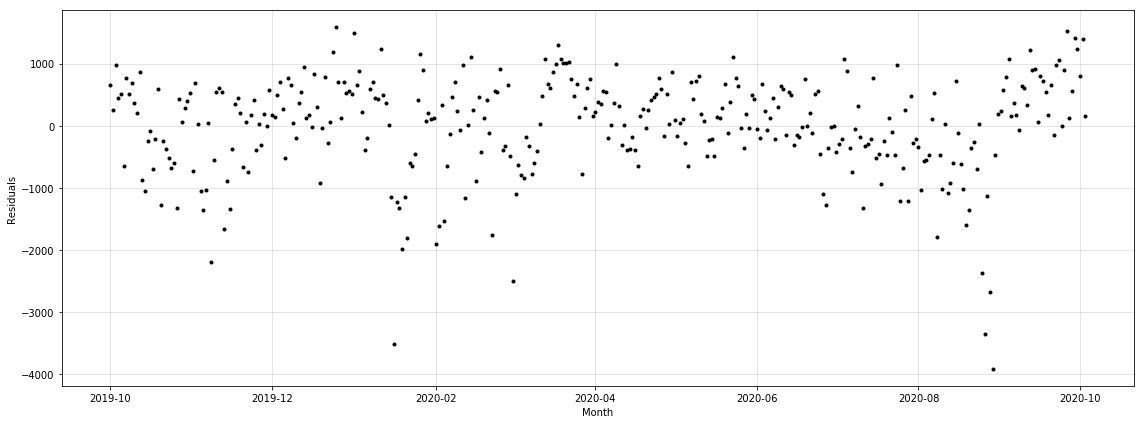

In [68]:
xlabel='Month'
ylabel='Residuals'
fig = plt.figure(facecolor='w', figsize=(16, 6))

ax = fig.add_subplot(111)
fcst_t = forecast['ds'].dt.to_pydatetime()
ax.plot(df_estimate['ds'].dt.to_pydatetime(), df_estimate['residuals'], 'k.')

ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

fig.tight_layout()

#### R squared value

In [71]:
r2_score(df_estimate.y, df_estimate.yhat)

0.3161392878057053

# Next steps

Is one year data enough for fitting?  
Should I replace outlies? Or use moving average?  